# **Spark ML**

## 0 - Usual preamble to a `Spark` notebook on google.colab

In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
!update-alternatives --set java /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java
!java -version
!pip install pyspark

openjdk version "1.8.0_222"
OpenJDK Runtime Environment (build 1.8.0_222-8u222-b10-1ubuntu1~18.04.1-b10)
OpenJDK 64-Bit Server VM (build 25.222-b10, mixed mode)


Let's load the data.


In [0]:
from google.colab import files
files.upload()  # upload 'data.zip'

Saving data (2).zip to data (2) (1).zip


{'data (2).zip': b'PK\x03\x04\x14\x03\x00\x00\x08\x00Q\x1c4O\x94\x9b\x18\xdcK\xe7\x01\x00\xb0\x05\x0e\x00\x08\x00\x00\x00bank.csv\x9c\x9d\xddV\xac5\x0c\x86\xcf\xbd\x96\xe2j~\x9b\\\x0e"*\x8a\xe0B\xd0\xe5\xdd;83(\xf3\xbd\x99\xe0w\xa0\xc3^\xb0\x9f\x9d4i\x9a\xa6i\xb9\xfd\xf1~\xfc\xfc\xfc\xdd\xf8\xf5\xf6\xe5\xe1\xf5\xf6q\xdc\x7f\xffvw\xfb\xfa\xf0\xfc4\xbe\xbf\xff\xe1\xf6\xed\xf1u|w\xfbx\xfbtw?~z~\xfb\xfd\xe1\xe9\xc7\xf1\xf8|\xfb4\xee\x9e\x9f^o\xef^\xc7\xf7\xb7\x7f\x8d_\x0f_\xff4\xbe\x7f{9\xfe\xbd\xbb\xdb_\x7f\xbb}\xf8\xf1i\xfcv\xf8\xe6\xef\xe3\xb7\x97\xfb?\x1e\x9e\xdf\x0e_<\xbf\xbd\xde=\xffz\x7f\x00\xff\xf6\xfc\xfb\xc3\xeb7\x96\xe3\xf6\xfb_\x1f\x9e\xbe}\xff\xc7_\x1e\xee\xbf\x1f\xbf\xdf\x1f\xb8\xdf\xdf\xbe\xfc5\x9e\x9e\x07\x8b\xca\xf8\xeb\xfe\xf7\xf7\xaf\xdf\x9e~yz\xfe\xf3i\xd8\xe1G\xff\x1a4\x95\x07\x8d\x1b\x1a\xf3\xfc\x9d\xf7\x1f\xfc\xc6\xfc*P\xed\xf0\x7f@S_\x88\xa64^\xef\xef~zz\xb8{\xb8}\xc2D\xe25\x0b\x11%\x12\x8ah\x07\xc2\xcb\x1f\x0fw\xf7\xbf\x17Z\xebr\x8c\xb4\x85\x89z\xa9\xf4\xeb\xfd\xcb

In [0]:
!ls

'data (2).zip'	 sample_data


In [0]:
import zipfile
with zipfile.ZipFile('data (2).zip', 'r') as zipf:
  zipf.extractall('.')

In [0]:
!ls

 bank.csv   boston.csv	'data (2).zip'	 sample_data


You should have now `boston.csv` and `bank.csv` in your folder.

## Example 1: Housing prices in Boston. Linear regression

The goal is to predict the housing prices in the Boston area.
Upload the data to your environment using the `google.colab.files` module.

The data is as follows:
  * `crim` — per capita crime rate by town.
  * `zn` — proportion of residential land zoned for lots over 25,000 sq.ft.
  * `indus` — proportion of non-retail business acres per town.
  * `chas` — Charles River dummy variable (= 1 if tract bounds river; 0 otherwise).
  * `nox` — nitrogen oxides concentration (parts per 10 million).
  * `rm` — average number of rooms per dwelling.
  * `age` — proportion of owner-occupied units built prior to 1940.
  * `dis` — weighted mean of distances to five Boston employment centres.
  * `rad` — index of accessibility to radial highways.
  * `tax` — full-value property-tax rate per $10,000.
  * `ptratio` — pupil-teacher ratio by town.
  * `black` — 1000(Bk — 0.63)<sup>2</sup> where Bk is the proportion of blacks by town.
  * `lstat` — lower status of the population (percent).
  * `medv` — median value of owner-occupied homes in \$1000s. **This is the target variable.**

In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType

In [0]:
spark = SparkSession.builder.appName('sparkMLnotebook').getOrCreate()

In [0]:
bostondf = spark.read.load("boston.csv", format="csv", sep=",", inferSchema="true", header="true")

In [0]:
bostondf.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- crim: double (nullable = true)
 |-- zn: double (nullable = true)
 |-- indus: double (nullable = true)
 |-- chas: integer (nullable = true)
 |-- nox: double (nullable = true)
 |-- rm: double (nullable = true)
 |-- age: double (nullable = true)
 |-- dis: double (nullable = true)
 |-- rad: integer (nullable = true)
 |-- tax: integer (nullable = true)
 |-- ptratio: double (nullable = true)
 |-- black: double (nullable = true)
 |-- lstat: double (nullable = true)
 |-- medv: double (nullable = true)



In [0]:
bostondf.show(3)

+---+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+
|_c0|   crim|  zn|indus|chas|  nox|   rm| age|   dis|rad|tax|ptratio| black|lstat|medv|
+---+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+
|  1|0.00632|18.0| 2.31|   0|0.538|6.575|65.2|  4.09|  1|296|   15.3| 396.9| 4.98|24.0|
|  2|0.02731| 0.0| 7.07|   0|0.469|6.421|78.9|4.9671|  2|242|   17.8| 396.9| 9.14|21.6|
|  3|0.02729| 0.0| 7.07|   0|0.469|7.185|61.1|4.9671|  2|242|   17.8|392.83| 4.03|34.7|
+---+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+
only showing top 3 rows



We can have basic stats on our dataset by simply calling the `.describe()` action on top of our dataframe. 

`transpose()` for readability purposes.

In [0]:
bostondf.describe().toPandas().transpose()

0                   1                    2        3        4
summary  count                mean               stddev      min      max
_c0        506               253.5    146.2138844296259        1      506
crim       506  3.6135235573122535    8.601545105332491  0.00632  88.9762
zn         506  11.363636363636363    23.32245299451514      0.0    100.0
indus      506  11.136778656126504    6.860352940897589     0.46    27.74
chas       506  0.0691699604743083   0.2539940413404101        0        1
nox        506  0.5546950592885372  0.11587767566755584    0.385    0.871
rm         506   6.284634387351787   0.7026171434153232    3.561     8.78
age        506   68.57490118577078   28.148861406903595      2.9    100.0
dis        506   3.795042687747034     2.10571012662761   1.1296  12.1265
rad        506   9.549407114624506    8.707259384239366        1       24
tax        506   408.2371541501976   168.53711605495903      187      711
ptratio    506  18.455533596837967   2.1649455237144455     12.6     22.0
black      506  356.67403162055257    91.29486438415782     0.32    396.9
lstat      506  12.653063241106723    7.141061511348571     1.73    37.97
medv       506  22.532806324110698    9.197104087379815      5.0     50.0

Scatter matrix is a great way to roughly determine if we have a linear correlation between multiple independent variables. `pandas` does it for us.


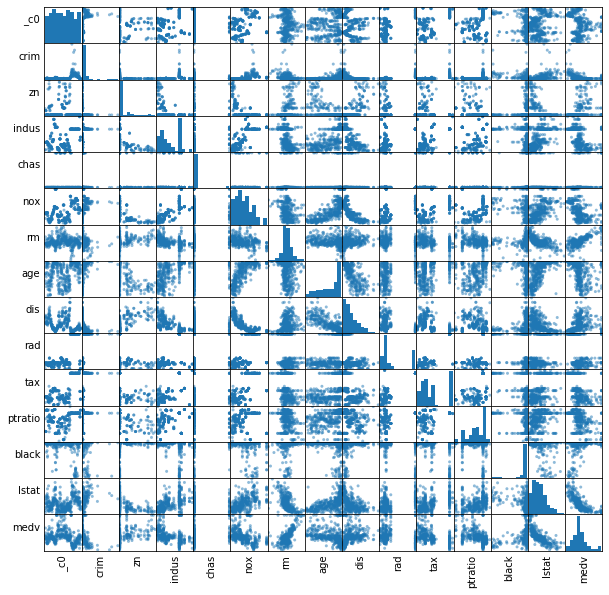

In [0]:
import pandas as pd

numeric_features = [t[0] for t in bostondf.dtypes if t[1] == 'int' or t[1] == 'double']
sampled_data = bostondf.select(numeric_features).sample(False, 0.8).toPandas()
axs = pd.plotting.scatter_matrix(sampled_data, figsize=(10, 10))
n = len(sampled_data.columns)

for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

It's hard to see.

Let's compute all correlations with the target variable (`medv`)

In [0]:
for c1 in bostondf.columns:
  if c1 == '_c0' or c1 == 'medv':
    continue
  print('corr({}, medv) = {}'.format(c1, bostondf.stat.corr(c1, 'medv')))

corr(crim, medv) = -0.38830460858681154
corr(zn, medv) = 0.3604453424505433
corr(indus, medv) = -0.48372516002837285
corr(chas, medv) = 0.17526017719029868
corr(nox, medv) = -0.42732077237328203
corr(rm, medv) = 0.6953599470715401
corr(age, medv) = -0.3769545650045961
corr(dis, medv) = 0.249928734085904
corr(rad, medv) = -0.38162623063977735
corr(tax, medv) = -0.46853593356776674
corr(ptratio, medv) = -0.5077866855375623
corr(black, medv) = 0.3334608196570662
corr(lstat, medv) = -0.7376627261740145


Nothing serious... We keep all the variables, for now.

To prepare the data we need features and labels.
Being that data is numerical, we do not have to perform any encoding. Just build the `Vector`.

In [0]:
from pyspark.ml.feature import VectorAssembler

input_columns = [col for col in bostondf.columns if col not in ['_c0', 'medv']]

features = VectorAssembler(inputCols=input_columns, outputCol='features')

v_df = features.transform(bostondf)
v_df = v_df.select(['features', 'medv'])
v_df.show(3)

+--------------------+----+
|            features|medv|
+--------------------+----+
|[0.00632,18.0,2.3...|24.0|
|[0.02731,0.0,7.07...|21.6|
|[0.02729,0.0,7.07...|34.7|
+--------------------+----+
only showing top 3 rows



Let's split the dataset into training and testing sets with a 70:30 ratio

In [0]:
splits = v_df.randomSplit([0.7, 0.3])
train_df = splits[0]
test_df = splits[1]

### **Linear regression**

See the [docs](https://spark.apache.org/docs/2.2.0/ml-classification-regression.html#linear-regression).

In [0]:
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol = 'features', labelCol='medv', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(train_df)
print("Coefficients: ", lr_model.coefficients)
print("Intercept: ", lr_model.intercept)

Coefficients:  [-0.023641400703739886,0.004251948460164606,0.0,3.1388357979400925,-1.8985629574558565,5.547168845413469,0.0,-0.43325636532029116,0.0,0.0,-0.6820404494231318,0.013298025468348174,-0.4647685025747973]
Intercept:  3.989609397050135


In [0]:
trainingSummary = lr_model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

RMSE: 4.967559
r2: 0.714116


RMSE measures the differences between predicted values by the model and the actual values. However, RMSE alone is meaningless until we compare with the actual `medv` value, such as mean, min and max. After such comparison, our RMSE looks pretty good.


In [0]:
train_df.describe().show()

+-------+-----------------+
|summary|             medv|
+-------+-----------------+
|  count|              353|
|   mean|22.56968838526914|
| stddev| 9.30388263064905|
|    min|              7.0|
|    max|             50.0|
+-------+-----------------+



Pretty good. `stddev` is 9, and we have a lower error.

R squared at `0.71` indicates that in our model, roughly `71%` of the variability in `medv` can be explained using the model. 

However, the performance on the training set may not a good approximation of the performance on the test set.

In [0]:
lr_predictions = lr_model.transform(test_df)
lr_predictions.select("prediction","medv","features").show(5)

+------------------+----+--------------------+
|        prediction|medv|            features|
+------------------+----+--------------------+
|30.930388913858256|32.2|[0.00906,90.0,2.9...|
| 32.54284635567008|32.7|[0.01301,35.0,1.5...|
|27.513988813011057|24.5|[0.01501,80.0,2.0...|
| 42.66516345829181|50.0|[0.01501,90.0,1.2...|
| 31.33869244132445|32.9|[0.01778,95.0,1.4...|
+------------------+----+--------------------+
only showing top 5 rows



In [0]:
from pyspark.ml.evaluation import RegressionEvaluator
lr_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="medv", metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(lr_predictions))

R Squared (R2) on test data = 0.683034


In [0]:
test_result = lr_model.evaluate(test_df)
print("Root Mean Squared Error (RMSE) on test data = %g" % test_result.rootMeanSquaredError)


Root Mean Squared Error (RMSE) on test data = 5.03659


In [0]:
print("numIterations: %d" % trainingSummary.totalIterations)
print("objectiveHistory: %s" % str(trainingSummary.objectiveHistory))

trainingSummary.residuals.show()

numIterations: 11
objectiveHistory: [0.4999999999999991, 0.4357347235705922, 0.23601852202659043, 0.20897035544109752, 0.18103518737083352, 0.17869429186380056, 0.17808870537878463, 0.17752646871324176, 0.17725386964266834, 0.1771725471405849, 0.1771409890594826]
+-------------------+
|          residuals|
+-------------------+
| -6.273405098393951|
| -5.103345743807193|
|  4.528549716770936|
|  1.871444272032111|
|  11.19426972212419|
| 0.6729655819317308|
| -0.655733265976842|
|  8.924985763503159|
|  3.012648437963364|
|-2.9375709685123965|
|  5.513250718941457|
|-0.2392747151702963|
|-1.0960932045908613|
|  5.464236992437655|
|  0.337619920115646|
|-10.389880474614035|
| -4.001371217420033|
|  -3.85456338268958|
| 2.2892573848835163|
| -1.063300094020338|
+-------------------+
only showing top 20 rows



We can use the model to make some predictions.

In [0]:
predictions = lr_model.transform(test_df)
predictions.select("prediction", "medv", "features").show()


+------------------+----+--------------------+
|        prediction|medv|            features|
+------------------+----+--------------------+
|17.981434699437404|18.9|[0.0136,75.0,4.0,...|
| 30.95189085018329|34.7|[0.02729,0.0,7.07...|
|25.266432558361615|21.6|[0.02731,0.0,7.07...|
|26.002592580937094|28.7|[0.02985,0.0,2.18...|
| 29.44818650013538|31.2|[0.03049,55.0,3.7...|
|30.936908812558734|34.9|[0.0315,95.0,1.47...|
|29.517146666949458|33.4|[0.03237,0.0,2.18...|
| 32.07006294203498|34.9|[0.03359,75.0,2.9...|
|20.328195308981613|19.5|[0.03427,0.0,5.19...|
|27.621623898180022|22.0|[0.03537,34.0,6.0...|
|24.427089428779038|22.9|[0.03551,25.0,4.8...|
| 28.72121754725445|27.9|[0.03615,80.0,4.9...|
| 22.98409660455328|20.7|[0.03738,0.0,5.19...|
|26.287514786589938|23.2|[0.03871,52.5,5.3...|
| 26.42058648206432|24.8|[0.04297,52.5,5.3...|
| 22.23745949564227|20.6|[0.04527,0.0,11.9...|
| 32.52062252924022|30.3|[0.04666,80.0,1.5...|
|26.202673155115683|22.6|[0.04684,0.0,3.41...|
| 27.87294873

### Decision tree regression

See the [docs](https://spark.apache.org/docs/2.2.0/ml-classification-regression.html#decision-tree-regression).

In [0]:
from pyspark.ml.regression import DecisionTreeRegressor
dt = DecisionTreeRegressor(featuresCol ='features', labelCol = 'medv')
dt_model = dt.fit(train_df)
dt_predictions = dt_model.transform(test_df)

dt_evaluator = RegressionEvaluator(labelCol="medv", predictionCol="prediction", metricName="rmse")

rmse = dt_evaluator.evaluate(dt_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 4.81132


### Gradient-boosted tree regression

See the [docs](https://spark.apache.org/docs/2.2.0/ml-classification-regression.html#gradient-boosted-tree-regression).

In [0]:
from pyspark.ml.regression import GBTRegressor
gbt = GBTRegressor(featuresCol = 'features', labelCol = 'medv', maxIter=10)
gbt_model = gbt.fit(train_df)
gbt_predictions = gbt_model.transform(test_df)
gbt_predictions.select('prediction', 'medv', 'features').show(5)


+------------------+----+--------------------+
|        prediction|medv|            features|
+------------------+----+--------------------+
|30.121119413446287|32.2|[0.00906,90.0,2.9...|
|  35.3371293811388|32.7|[0.01301,35.0,1.5...|
|28.370553981744916|24.5|[0.01501,80.0,2.0...|
| 45.50397542000706|50.0|[0.01501,90.0,1.2...|
| 38.71019832751575|32.9|[0.01778,95.0,1.4...|
+------------------+----+--------------------+
only showing top 5 rows



In [0]:
gbt_evaluator = RegressionEvaluator(
    labelCol="medv", predictionCol="prediction", metricName="rmse")
rmse = gbt_evaluator.evaluate(gbt_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 5.53164


It looks like in our case `Gradient-boosted tree regression` outperformed by little margin all the other methods.


## Example 2: Bank app. Binary classification

In [44]:
bankdf = spark.read.csv('bank.csv', header = True, inferSchema = True)
bankdf.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



Input variables: age, job, marital, education, default, balance, housing, loan, contact, day, month, duration, campaign, pdays, previous, poutcome.

Output variable: **deposit**

In [0]:
pd.DataFrame(bankdf.take(5), columns=bankdf.columns).transpose()

0          1           2          3         4
age               59         56          41         55        54
job           admin.     admin.  technician   services    admin.
marital      married    married     married    married   married
education  secondary  secondary   secondary  secondary  tertiary
default           no         no          no         no        no
balance         2343         45        1270       2476       184
housing          yes         no         yes        yes        no
loan              no         no          no         no        no
contact      unknown    unknown     unknown    unknown   unknown
day                5          5           5          5         5
month            may        may         may        may       may
duration        1042       1467        1389        579       673
campaign           1          1           1          1         2
pdays             -1         -1          -1         -1        -1
previous           0          0           0          0         0
poutcome     unknown    unknown     unknown    unknown   unknown
deposit          yes        yes         yes        yes       yes

Let's see if the dataset is balanced (*hint: yes*)

In [0]:
bankdf.groupBy('deposit').count().show()

+-------+-----+
|deposit|count|
+-------+-----+
|     no| 5873|
|    yes| 5289|
+-------+-----+



Summary statistics of continous variables.

In [0]:
numeric_features = [t[0] for t in bankdf.dtypes if t[1] == 'int']
bankdf.select(numeric_features).describe().toPandas().transpose()

0                   1                   2      3      4
summary   count                mean              stddev    min    max
age       11162  41.231947679627304  11.913369192215518     18     95
balance   11162  1528.5385235620856   3225.413325946149  -6847  81204
day       11162  15.658036194230425   8.420739541006462      1     31
duration  11162  371.99381831213043  347.12838571630687      2   3881
campaign  11162   2.508421429851281  2.7220771816614824      1     63
pdays     11162   51.33040673714388  108.75828197197717     -1    854
previous  11162  0.8325568894463358   2.292007218670508      0     58

As before, let's look at correlations.

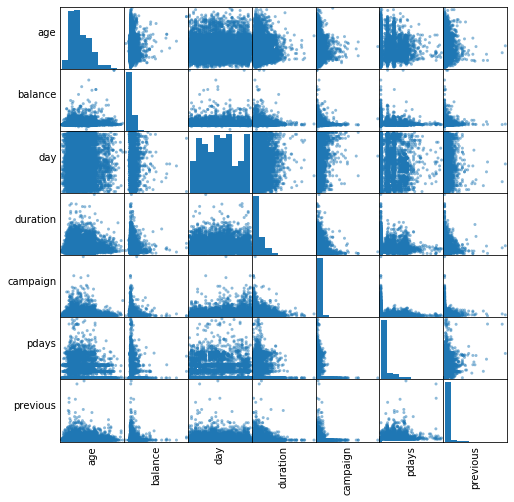

In [0]:
numeric_data = bankdf.select(numeric_features).toPandas()
axs = pd.plotting.scatter_matrix(numeric_data, figsize=(8, 8))

n = len(numeric_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

As in the previous case, no highly correlated numeric variables: keep all variables. However, day and month columns are not really useful, we will remove these two columns.

In [0]:
df = bankdf.select('age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'deposit')
cols = df.columns
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



We have categorical variables... `OneHotEncoderEstimator` and `StringIndexer` FTW...

In [0]:
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer

categoricalColumns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']

stages = []

for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]

label_stringIdx = StringIndexer(inputCol = 'deposit', outputCol = 'label')
stages += [label_stringIdx]

numericCols = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']

assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")

stages += [assembler]

Once we have our stages ready, it's time to build the `pipeline`.

In [0]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages = stages)

pipelineModel = pipeline.fit(df)

df = pipelineModel.transform(df)

selectedCols = ['label', 'features'] + cols

df = df.select(selectedCols)
df.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



In [0]:
pd.DataFrame(df.take(5), columns=df.columns).transpose()

0  ...                                                  4
label                                                      1  ...                                                  1
features   (0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  ...  (0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
age                                                       59  ...                                                 54
job                                                   admin.  ...                                             admin.
marital                                              married  ...                                            married
education                                          secondary  ...                                           tertiary
default                                                   no  ...                                                 no
balance                                                 2343  ...                                                184
housing                                                  yes  ...                                                 no
loan                                                      no  ...                                                 no
contact                                              unknown  ...                                            unknown
duration                                                1042  ...                                                673
campaign                                                   1  ...                                                  2
pdays                                                     -1  ...                                                 -1
previous                                                   0  ...                                                  0
poutcome                                             unknown  ...                                            unknown
deposit                                                  yes  ...                                                yes

[17 rows x 5 columns]

In [0]:
train, test = df.randomSplit([0.7, 0.3], seed = 2019)  # seed for reproducibility
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 7797
Test Dataset Count: 3365


## Logistic regression

In [0]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)

lrModel = lr.fit(train)

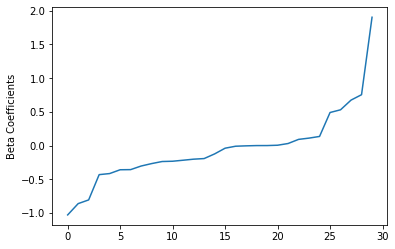

In [0]:
# We can obtain the coefficients by using LogisticRegressionModel’s attributes.
import matplotlib.pyplot as plt
import numpy as np


beta = np.sort(lrModel.coefficients)

plt.plot(beta)

plt.ylabel('Beta Coefficients')
plt.show()

Summarize the model over the training set, we can also obtain the receiver-operating characteristic and `areaUnderROC`.

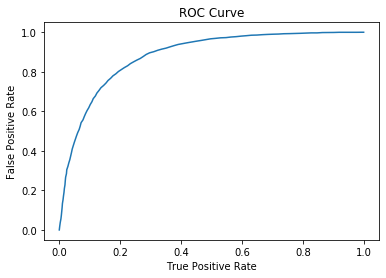

Training set areaUnderROC: 0.8815929117182412


In [0]:
trainingSummary = lrModel.summary

roc = trainingSummary.roc.toPandas()

plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')

plt.show()

print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

### Precision and recall

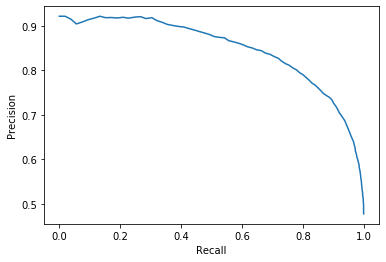

In [0]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [0]:
predictions = lrModel.transform(test)
predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+----------+-----+--------------------+----------+--------------------+
|age|       job|label|       rawPrediction|prediction|         probability|
+---+----------+-----+--------------------+----------+--------------------+
| 35|management|  0.0|[1.83684017311713...|       0.0|[0.86257457150535...|
| 37|management|  0.0|[1.09545245219006...|       0.0|[0.74940706275753...|
| 52|management|  0.0|[-0.7580329997110...|       1.0|[0.31907347552060...|
| 53|management|  0.0|[0.94350855877318...|       0.0|[0.71980782482734...|
| 57|management|  0.0|[1.16964488183736...|       0.0|[0.76308082045143...|
| 61|management|  0.0|[0.91100869557153...|       0.0|[0.71320652871014...|
| 46|management|  0.0|[2.14433999990620...|       0.0|[0.89513868555609...|
| 36|management|  0.0|[1.05660385286932...|       0.0|[0.74204100243643...|
| 40|management|  0.0|[1.48064527231765...|       0.0|[0.81467002549477...|
| 40|management|  0.0|[1.30280957111630...|       0.0|[0.78630744952447...|
+---+-------

In [0]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator()

print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.8948427991670396


## Decision Tree Classifier

Decision trees are widely used since they are easy to interpret, handle categorical features, extend to the multi-class classification, do not require feature scaling, and are able to capture non-linearities and feature interactions.

In [0]:
from pyspark.ml.classification import DecisionTreeClassifier

dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 3)

dtModel = dt.fit(train)

predictions = dtModel.transform(test)

predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+----------+-----+--------------+----------+--------------------+
|age|       job|label| rawPrediction|prediction|         probability|
+---+----------+-----+--------------+----------+--------------------+
| 35|management|  0.0|[732.0,1082.0]|       1.0|[0.40352811466372...|
| 37|management|  0.0|[2449.0,503.0]|       0.0|[0.82960704607046...|
| 52|management|  0.0|[503.0,1936.0]|       1.0|[0.20623206232062...|
| 53|management|  0.0|[2449.0,503.0]|       0.0|[0.82960704607046...|
| 57|management|  0.0|[2449.0,503.0]|       0.0|[0.82960704607046...|
| 61|management|  0.0|[2449.0,503.0]|       0.0|[0.82960704607046...|
| 46|management|  0.0|[2449.0,503.0]|       0.0|[0.82960704607046...|
| 36|management|  0.0|  [349.0,21.0]|       0.0|[0.94324324324324...|
| 40|management|  0.0|  [349.0,21.0]|       0.0|[0.94324324324324...|
| 40|management|  0.0|  [349.0,21.0]|       0.0|[0.94324324324324...|
+---+----------+-----+--------------+----------+--------------------+
only showing top 10 

In [0]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.782761174538419


One simple decision tree performed poorly because it is too weak given the range of different features. The prediction accuracy of decision trees can be improved by Ensemble methods, such as `Random Forest` and `Gradient-Boosted Tree`.

## Random Forest Classifier

In [0]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')

rfModel = rf.fit(train)

predictions = rfModel.transform(test)

predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+----------+-----+--------------------+----------+--------------------+
|age|       job|label|       rawPrediction|prediction|         probability|
+---+----------+-----+--------------------+----------+--------------------+
| 35|management|  0.0|[13.0807907506487...|       0.0|[0.65403953753243...|
| 37|management|  0.0|[13.5655092126319...|       0.0|[0.67827546063159...|
| 52|management|  0.0|[6.84918831392042...|       1.0|[0.34245941569602...|
| 53|management|  0.0|[13.1861546065761...|       0.0|[0.65930773032880...|
| 57|management|  0.0|[13.3636186552726...|       0.0|[0.66818093276363...|
| 61|management|  0.0|[7.44860019733756...|       1.0|[0.37243000986687...|
| 46|management|  0.0|[15.3118293338326...|       0.0|[0.76559146669163...|
| 36|management|  0.0|[15.8060021704222...|       0.0|[0.79030010852111...|
| 40|management|  0.0|[15.4772031709305...|       0.0|[0.77386015854652...|
| 40|management|  0.0|[15.8060021704222...|       0.0|[0.79030010852111...|
+---+-------

In [0]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.8892244787297261


## Gradient-Boosted Tree Classifier

In [0]:
from pyspark.ml.classification import GBTClassifier

gbt = GBTClassifier(maxIter=10)

gbtModel = gbt.fit(train)

predictions = gbtModel.transform(test)
predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)



+---+----------+-----+--------------------+----------+--------------------+
|age|       job|label|       rawPrediction|prediction|         probability|
+---+----------+-----+--------------------+----------+--------------------+
| 35|management|  0.0|[0.00523863003964...|       0.0|[0.50261929105925...|
| 37|management|  0.0|[0.45611759846541...|       0.0|[0.71345733533148...|
| 52|management|  0.0|[-0.6139332433376...|       1.0|[0.22655505859473...|
| 53|management|  0.0|[0.03698770815621...|       0.0|[0.51848542493511...|
| 57|management|  0.0|[0.45611759846541...|       0.0|[0.71345733533148...|
| 61|management|  0.0|[-0.3904664207042...|       1.0|[0.31411887221274...|
| 46|management|  0.0|[1.31338130936222...|       0.0|[0.93256424129022...|
| 36|management|  0.0|[0.98079391560200...|       0.0|[0.87670468947647...|
| 40|management|  0.0|[0.76957704719894...|       0.0|[0.82334172179109...|
| 40|management|  0.0|[0.97202467792988...|       0.0|[0.87479633368517...|
+---+-------

In [0]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.9037395969515111


Gradient-Boosted Tree achieved the best results, we will try tuning this model with the `ParamGridBuilder` and the `CrossValidator`. Before that we can use `explainParams()` to print a list of all params and their definitions to understand what params available for tuning.

In [0]:
print(gbt.explainParams())

cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featureSubsetStrategy: The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1/3 of the features), 'sqrt' (use sqrt(number of features)), 'log2' (use log2(number of features)), 

In [0]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

paramGrid = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, [2, 4, 6])
             .addGrid(gbt.maxBins, [20, 60])
             .addGrid(gbt.maxIter, [10, 20])
             .build())

cv = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5) # Run cross validations.  This can take about 6 minutes since it is training over 20 trees!
cvModel = cv.fit(train)
predictions = cvModel.transform(test)
evaluator.evaluate(predictions)

0.9085021455511194

Tuning parameters paid off even on an already *winning* model.